In [1]:
# Install dependencies (only needed in Google Colab)
# In Azure Databricks, skip this cell
!pip install pyspark==3.5.1 delta-spark==3.1.0
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached delta_spark-3.1.0-py3-none-any.whl.metadata (1.9 kB)
Using cached delta_spark-3.1.0-py3-none-any.whl (21 kB)
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=927df0dccad06bcbe5beab064995b9e0f7828f1702bc81ad677f8674c8baf4c0
  Stored in directory: /root/.cache/pip/wheels/95/13/41/f7f135ee114175605fb4f0a89e7389f3742aa6c1e1a5bcb657
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.0
    Uninstalling pyspark-3.5.0:
      Successfully uninstalled pyspark-3.5.0
  Attempting uninstall: delta-spark
    Found existing installation: delta-spark 3.2.0
    Uninstalling delta-spark-3.2.0:
      Successfully uninstalled delta-spark-3.2.0


In [2]:
# using DELTA in colab
!pip install delta-spark==3.2.0 -q
import pyspark
from delta import *
from pyspark.sql.functions import *

# Create a SparkSession with Delta Lake extensions
# The '.config(...)' lines are crucial for enabling Delta Lake's features
builder = pyspark.sql.SparkSession.builder.appName("DeltaRideHailing") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

# Get or create the SparkSession
spark = configure_spark_with_delta_pip(builder).getOrCreate()

print("Spark and Delta Lake are ready!")


Spark and Delta Lake are ready!


# Dataset: Ride-Hailing Trips + Drivers

In [3]:
from pyspark.sql import types as T
from datetime import datetime

# Trip schema
trip_schema = T.StructType([
    T.StructField("trip_id",      T.IntegerType()),
    T.StructField("rider_id",     T.StringType()),
    T.StructField("driver_id",    T.StringType()),
    T.StructField("city",         T.StringType()),
    T.StructField("distance_km",  T.DoubleType()),
    T.StructField("fare",         T.DoubleType()),
    T.StructField("tip",          T.DoubleType()),
    T.StructField("ts",           T.TimestampType())
])

# Driver schema
driver_schema = T.StructType([
    T.StructField("driver_id",   T.StringType()),
    T.StructField("driver_name", T.StringType()),
    T.StructField("rating",      T.DoubleType()),
    T.StructField("vehicle",     T.StringType())
])

# Trip data (using Python datetime for timestamps)
trips_rows = [
    (1001,"R001","D010","Bengaluru", 12.4, 320.0, 20.0, datetime(2025, 8, 8, 8, 5, 0)),
    (1002,"R002","D011","Hyderabad",  6.2, 150.0, 10.0, datetime(2025, 8, 8, 8, 15, 0)),
    (1003,"R003","D012","Pune",       3.5,  90.0,  0.0, datetime(2025, 8, 8, 8, 20, 0)),
    (1004,"R001","D010","Bengaluru", 18.9, 480.0, 25.0, datetime(2025, 8, 8, 8, 45, 0)),
    (1005,"R004","D013","Chennai",   10.0, 260.0, 15.0, datetime(2025, 8, 8, 9, 5, 0)),
    (1006,"R005","D012","Pune",       2.2,  70.0,  0.0, datetime(2025, 8, 8, 9, 10, 0)),
]

# Driver data
drivers_rows = [
    ("D010","Anil",   4.8,"WagonR"),
    ("D011","Sana",   4.6,"i20"),
    ("D012","Rakesh", 4.4,"Swift"),
    ("D013","Meera",  4.9,"Ciaz")
]

# Create DataFrames
trips_df   = spark.createDataFrame(trips_rows, schema=trip_schema)
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)

# Save to Delta paths
BASE = "/content/delta/ride_hailing"
TRIPS_PATH   = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"

trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)

print("Data seeded successfully.")
print("Trips path  ->", TRIPS_PATH)
print("Drivers path->", DRIVERS_PATH)


Data seeded successfully.
Trips path  -> /content/delta/ride_hailing/trips
Drivers path-> /content/delta/ride_hailing/drivers


# Exercises


# 1) Managed vs Unmanaged Tables

 Create a managed Delta table trips_managed by AS SELECT from the Delta path.


In [4]:
spark.sql(f"""
    CREATE TABLE trips_managed
    USING DELTA
    AS SELECT * FROM delta.`{TRIPS_PATH}`
""")
print("Managed table 'trips_managed' created successfully.")


Managed table 'trips_managed' created successfully.


Create an external (unmanaged) table drivers_ext that points to DRIVERS_PATH.

In [5]:
spark.sql(f"""
    CREATE TABLE drivers_unmanaged
    USING DELTA
    LOCATION '{DRIVERS_PATH}'
""")
print("Unmanaged table 'drivers_unmanaged' created successfully.")

Unmanaged table 'drivers_unmanaged' created successfully.


Verify locations with DESCRIBE DETAIL and explain the difference in your own
 words.

In [6]:
print("Managed table details:")
spark.sql("DESCRIBE DETAIL trips_managed").show(truncate=False)

print("Unmanaged table details:")
spark.sql("DESCRIBE DETAIL drivers_unmanaged").show(truncate=False)

Managed table details:
+------+------------------------------------+-----------------------------------+-----------+-------------------------------------------+-----------------------+-----------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                               |description|location                                   |createdAt              |lastModified           |partitionColumns|clusteringColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+-----------------------------------+-----------+-------------------------------------------+-----------------------+-----------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|delta |5e1765da-8fba-4eb5-86f2-03fe5f9f2

# 2) Read & Explore

 Read both tables, print schemas, and show 10 rows.


In [7]:
# Read the managed and unmanaged tables
trips_df_q2 = spark.sql("SELECT * FROM trips_managed")
drivers_df_q2 = spark.sql("SELECT * FROM drivers_unmanaged")

# Show schemas and first 10 rows
print("Trips table schema:")
trips_df_q2.printSchema()
print("First 10 trips:")
trips_df_q2.show(10)

print("Drivers table schema:")
drivers_df_q2.printSchema()
print("First 10 drivers:")
drivers_df_q2.show(10)


Trips table schema:
root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

First 10 trips:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:0

 Compute a derived column total_amount = fare + tip and show top 5 trips by
 total_amount.

In [8]:
from pyspark.sql import functions as F

trips_with_total = trips_df_q2.withColumn("total_amount", F.col("fare") + F.col("tip"))

trips_with_total.orderBy(F.desc("total_amount")).show(5)


+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|       505.0|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|       340.0|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|       275.0|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|       160.0|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|        90.0|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
only showing top 5 rows



# 3) Update (Business Rule)

Increase tip by 5 for trips in Bengaluru where distance_km > 15.

Show before/after for affected rows only.

In [9]:
from delta.tables import DeltaTable

# Load Delta table
trips_table_t3 = DeltaTable.forPath(spark, TRIPS_PATH)

# Show trips in Bengaluru with distance > 15 km before update
print("Before update:")
trips_table_t3.toDF().filter("city = 'Bengaluru' AND distance_km > 15").show()

Before update:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



In [11]:
# Increase tip by 5 for Bengaluru trips with distance > 15 km
trips_table_t3.update(
    condition="city = 'Bengaluru' AND distance_km > 15",
    set={"tip": "tip + 5"}
)
# Show affected rows after update
print("After update:")
trips_table_t3.toDF().filter("city = 'Bengaluru' AND distance_km > 15").show()


After update:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|35.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# 4) Delete (Data Quality)

Delete trips where fare <= 0 or distance_km <= 0 (simulate bad ingest)

In [12]:
trips_table_t4 = DeltaTable.forPath(spark, TRIPS_PATH)
trips_table_t4.delete("fare <= 0 OR distance_km <= 0")
print("Delete completed.")

Delete completed.


Show remaining row count.

In [13]:
remaining_count = trips_table_t4.toDF().count()
print(f"Remaining rows after deletion: {remaining_count}")

Remaining rows after deletion: 6


# 5) Merge (Upsert New Batch)

 Create a new inline batch with:

 one existing trip_id (e.g., 1004) but a corrected fare or tip, and

 one new trip (e.g., 1007). Perform a MERGE (match on
existing and insert the new.

 Show rows for
trip_id IN (1004,1007) to confirm.

In [14]:
from datetime import datetime
from delta.tables import DeltaTable

new_batch_rows = [
    (1004, "R001", "D010", "Bengaluru", 18.9, 500.0, 30.0, datetime(2025, 8, 8, 8, 45, 0)),
    (1007, "R006", "D011", "Hyderabad", 7.0, 180.0, 12.0, datetime(2025, 8, 8, 10, 0, 0))
]
new_batch_df = spark.createDataFrame(new_batch_rows, schema=trip_schema)

# Perform MERGE into trips table
trips_table_t5 = DeltaTable.forPath(spark, TRIPS_PATH)
trips_table_t5.alias("t").merge(
    new_batch_df.alias("n"),
    "t.trip_id = n.trip_id"
).whenMatchedUpdateAll() \
 .whenNotMatchedInsertAll() \
 .execute()

# Show rows for trip_id 1004 and 1007
trips_table_t5.toDF().filter("trip_id IN (1004, 1007)").show()


+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1007|    R006|     D011|Hyderabad|        7.0|180.0|12.0|2025-08-08 10:00:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# 6) Gold View (Join & KPIs)

Join trips with drivers on
 driver_id .

In [15]:

trips_latest_df = spark.read.format("delta").load(TRIPS_PATH)
drivers_latest_df = spark.read.format("delta").load(DRIVERS_PATH)

joined_df = trips_latest_df.join(drivers_latest_df, "driver_id")

print("Joined trips and drivers on driver_id:")
joined_df.show()

Joined trips and drivers on driver_id:
+---------+-------+--------+---------+-----------+-----+----+-------------------+-----------+------+-------+
|driver_id|trip_id|rider_id|     city|distance_km| fare| tip|                 ts|driver_name|rating|vehicle|
+---------+-------+--------+---------+-----------+-----+----+-------------------+-----------+------+-------+
|     D010|   1004|    R001|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|       Anil|   4.8| WagonR|
|     D013|   1005|    R004|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|      Meera|   4.9|   Ciaz|
|     D012|   1006|    R005|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|     Rakesh|   4.4|  Swift|
|     D011|   1007|    R006|Hyderabad|        7.0|180.0|12.0|2025-08-08 10:00:00|       Sana|   4.6|    i20|
|     D010|   1001|    R001|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|       Anil|   4.8| WagonR|
|     D011|   1002|    R002|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|       S

Create a gold view with columns:  trip_id, city, driver_name, rating
distance_km, total_amount, ts .


In [16]:
from pyspark.sql import functions as F

gold_df = joined_df.withColumn("total_amount", F.col("fare") + F.col("tip")) \
    .select(
        "trip_id",
        "city",
        "driver_name",
        "rating",
        "distance_km",
        "total_amount",
        "ts"
    )

print("Gold view created with selected columns:")
gold_df.show()


Gold view created with selected columns:
+-------+---------+-----------+------+-----------+------------+-------------------+
|trip_id|     city|driver_name|rating|distance_km|total_amount|                 ts|
+-------+---------+-----------+------+-----------+------------+-------------------+
|   1004|Bengaluru|       Anil|   4.8|       18.9|       530.0|2025-08-08 08:45:00|
|   1005|  Chennai|      Meera|   4.9|       10.0|       275.0|2025-08-08 09:05:00|
|   1006|     Pune|     Rakesh|   4.4|        2.2|        70.0|2025-08-08 09:10:00|
|   1007|Hyderabad|       Sana|   4.6|        7.0|       192.0|2025-08-08 10:00:00|
|   1001|Bengaluru|       Anil|   4.8|       12.4|       340.0|2025-08-08 08:05:00|
|   1002|Hyderabad|       Sana|   4.6|        6.2|       160.0|2025-08-08 08:15:00|
|   1003|     Pune|     Rakesh|   4.4|        3.5|        90.0|2025-08-08 08:20:00|
+-------+---------+-----------+------+-----------+------------+-------------------+



From this gold view:

 Compute city-wise total revenue and average driver rating.



In [17]:
from pyspark.sql import functions as F

city_kpis = gold_df.groupBy("city").agg(
    F.round(F.sum("total_amount"), 2).alias("city_revenue"),
    F.round(F.avg("rating"), 2).alias("avg_rating")
)

print("City-wise total revenue and average driver rating:")
city_kpis.show()


City-wise total revenue and average driver rating:
+---------+------------+----------+
|     city|city_revenue|avg_rating|
+---------+------------+----------+
|  Chennai|       275.0|       4.9|
|     Pune|       160.0|       4.4|
|Bengaluru|       870.0|       4.8|
|Hyderabad|       352.0|       4.6|
+---------+------------+----------+




 Compute driver-wise total trips and top 3 drivers by revenue.


In [18]:
from pyspark.sql import functions as F

driver_kpis = gold_df.groupBy("driver_name").agg(
    F.count("*").alias("total_trips"),
    F.round(F.sum("total_amount"), 2).alias("total_revenue")
)

print("Top 3 drivers by total revenue:")
driver_kpis.orderBy(F.desc("total_revenue")).show(3)


Top 3 drivers by total revenue:
+-----------+-----------+-------------+
|driver_name|total_trips|total_revenue|
+-----------+-----------+-------------+
|       Anil|          2|        870.0|
|       Sana|          2|        352.0|
|      Meera|          1|        275.0|
+-----------+-----------+-------------+
only showing top 3 rows



# 7) Time Travel & History

 Show DESCRIBE HISTORY for the trips table (the one you updated/merged).

In [19]:
spark.sql(f"DESCRIBE HISTORY delta.`{TRIPS_PATH}`").show(truncate=False)

+-------+-----------------------+------+--------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------------------+
|version|

 Read the table as of version 0, and compare counts and a few rows with the
 latest version

In [20]:
trips_v0 = spark.read.format("delta").option("versionAsOf", 0).load(TRIPS_PATH)
print("Trips table - Version 0:")
trips_v0.show()

trips_latest = spark.read.format("delta").load(TRIPS_PATH)
print("Trips table - Latest Version:")
trips_latest.show()

# Compare record counts
print(f"Version 0 count: {trips_v0.count()}, Latest version count: {trips_latest.count()}")


Trips table - Version 0:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

Trips table - Latest Version:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|dist

# 8) Partitioned Rewrite (Performance)

 Rewrite the trips table partitioned by
city into a new Delta path.

In [21]:
PARTITIONED_TRIPS_PATH = f"{BASE}/trips_partitioned"

spark.read.format("delta").load(TRIPS_PATH) \
    .write.format("delta") \
    .mode("overwrite") \
    .partitionBy("city") \
    .save(PARTITIONED_TRIPS_PATH)

print(f"Partitioned trips table saved at: {PARTITIONED_TRIPS_PATH}")


Partitioned trips table saved at: /content/delta/ride_hailing/trips_partitioned


Compare file layout (optional: list files) and run a simple filter
 city='Bengaluru' to observe read behavior/time.

In [22]:
partitioned_df = spark.read.format("delta").load(PARTITIONED_TRIPS_PATH) \
    .filter("city = 'Bengaluru'")

print("Trips in Bengaluru from partitioned table:")
partitioned_df.show()


Trips in Bengaluru from partitioned table:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# 9) Incremental Load Simulation

 Create a small incremental batch (e.g., trip_ids 1008–1009) with a new city
 (e.g., Mumbai).

In [24]:
from datetime import datetime

incremental_rows = [
    (1008, "R007", "D012", "Mumbai", 8.5, 300.0, 20.0, datetime(2025, 8, 8, 11, 0, 0)),
    (1009, "R008", "D013", "Mumbai", 5.2, 200.0, 15.0, datetime(2025, 8, 8, 11, 15, 0))
]
incremental_df = spark.createDataFrame(incremental_rows, schema=trip_schema)



 Append to the trips table.

In [25]:
incremental_df.write.format("delta").mode("append").save(TRIPS_PATH)

print("Incremental batch appended.")

Incremental batch appended.


 Re-run the city-wise revenue aggregation and note the change.

In [26]:
from pyspark.sql import functions as F

trips_after_incremental = spark.read.format("delta").load(TRIPS_PATH)

# City-wise total revenue
city_revenue_updated = trips_after_incremental.withColumn(
    "total_amount", F.col("fare") + F.col("tip")
).groupBy("city").agg(
    F.round(F.sum("total_amount"), 2).alias("city_revenue")
)

print("Updated city-wise revenue after incremental load:")
city_revenue_updated.show()


Updated city-wise revenue after incremental load:
+---------+------------+
|     city|city_revenue|
+---------+------------+
|  Chennai|       275.0|
|   Mumbai|      1070.0|
|     Pune|       160.0|
|Bengaluru|       870.0|
|Hyderabad|       352.0|
+---------+------------+



# 10) Simple Streaming (File Stream → Console)

Start a structured stream that reads Delta from TRIPS_PATH in readStream mode
and writes to console (append).


In [28]:

streaming_df = spark.readStream.format("delta").load(TRIPS_PATH)

stream_query = streaming_df.writeStream \
    .format("console") \
    .outputMode("append") \
    .trigger(processingTime="5 seconds") \
    .start()

print("Streaming started... run the next cell to append new data.")


Streaming started... run the next cell to append new data.


 While the stream runs, append another tiny batch (e.g., one more Mumbai trip)
 and observe the new row displayed.

In [29]:
from datetime import datetime

new_stream_batch = [
    (1010, "R009", "D011", "Mumbai", 9.0, 350.0, 25.0, datetime(2025, 8, 8, 11, 30, 0))
]
new_stream_df = spark.createDataFrame(new_stream_batch, schema=trip_schema)

# Append to trips table
new_stream_df.write.format("delta").mode("append").save(TRIPS_PATH)

print("New trip appended — check the stream output above.")


New trip appended — check the stream output above.


# 11) Visualization

Convert the gold view results (city revenue) to Pandas and plot a bar chart of
 city vs total revenue.

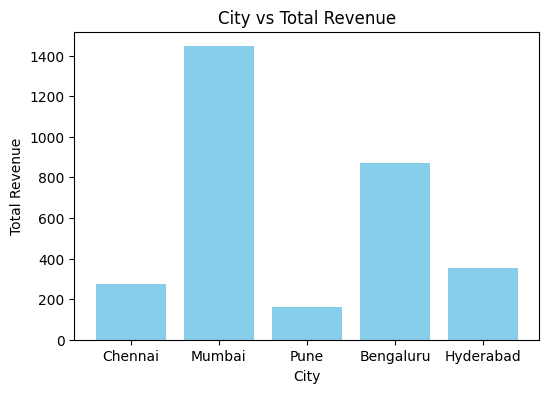

In [30]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

city_revenue_df = spark.read.format("delta").load(TRIPS_PATH) \
    .withColumn("total_amount", F.col("fare") + F.col("tip")) \
    .groupBy("city").agg(F.round(F.sum("total_amount"), 2).alias("city_revenue"))

city_revenue_pd = city_revenue_df.toPandas()

plt.figure(figsize=(6,4))
plt.bar(city_revenue_pd["city"], city_revenue_pd["city_revenue"], color='skyblue')
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.title("City vs Total Revenue")
plt.show()


Plot a line chart of hourly revenue: group by
 hour(ts) and sum
total_amount .


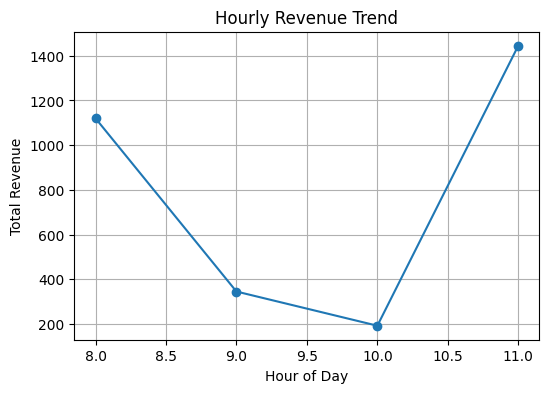

In [31]:
hourly_revenue_df = spark.read.format("delta").load(TRIPS_PATH) \
    .withColumn("total_amount", F.col("fare") + F.col("tip")) \
    .withColumn("hour", F.hour("ts")) \
    .groupBy("hour").agg(F.round(F.sum("total_amount"), 2).alias("hourly_revenue")) \
    .orderBy("hour")

hourly_revenue_pd = hourly_revenue_df.toPandas()

plt.figure(figsize=(6,4))
plt.plot(hourly_revenue_pd["hour"], hourly_revenue_pd["hourly_revenue"], marker='o')
plt.xlabel("Hour of Day")
plt.ylabel("Total Revenue")
plt.title("Hourly Revenue Trend")
plt.grid(True)
plt.show()


# 12) Managed vs Unmanaged Cleanup

DROP TABLE the managed and unmanaged tables; verify:

 Data for managed is removed with the table (when stored in the
 warehouse).

 Data for unmanaged stays at
DRIVERS_PATH after drop.

In [32]:
# Drop managed table
spark.sql("DROP TABLE IF EXISTS trips_managed")
print("Dropped managed table: trips_managed")

# Drop unmanaged table
spark.sql("DROP TABLE IF EXISTS drivers_unmanaged")
print("Dropped unmanaged table: drivers_unmanaged")

# Verify if managed table data is removed
import os

managed_path = "/content/spark-warehouse/trips_managed"
print("Managed table data exists after drop? ->", os.path.exists(managed_path))

# Verify if unmanaged table data still exists
unmanaged_exists = os.path.exists(DRIVERS_PATH)
print(f"Unmanaged table data exists at {DRIVERS_PATH}? ->", unmanaged_exists)


Dropped managed table: trips_managed
Dropped unmanaged table: drivers_unmanaged
Managed table data exists after drop? -> False
Unmanaged table data exists at /content/delta/ride_hailing/drivers? -> True


# 13) Constraint/Quality Check (Optional)

 Add a check to reject rows where
tip < 0 (enforce during write or simulate
 with a filter before save).

 Demonstrate an attempt to write bad data and show how you prevented it.

In [48]:
from pyspark.sql.functions import col

bad_data = spark.createDataFrame([
    (1, "CityA", 10.0, -2.0, 20.0),  # tip < 0
    (2, "CityB", 15.0, 3.0, 25.0)
], ["trip_id", "city", "fare", "tip", "total"])

# Show all data before filtering
print("All data (including bad tip):")
bad_data.show()

# Filter out rows with tip < 0
df_clean = bad_data.filter(col("tip") >= 0)

print("After enforcing tip >= 0:")
df_clean.show()



All data (including bad tip):
+-------+-----+----+----+-----+
|trip_id| city|fare| tip|total|
+-------+-----+----+----+-----+
|      1|CityA|10.0|-2.0| 20.0|
|      2|CityB|15.0| 3.0| 25.0|
+-------+-----+----+----+-----+

After enforcing tip >= 0:
+-------+-----+----+---+-----+
|trip_id| city|fare|tip|total|
+-------+-----+----+---+-----+
|      2|CityB|15.0|3.0| 25.0|
+-------+-----+----+---+-----+



# 14) Convert Parquet → Delta

 Save a small subset of trips as Parquet in a new folder and CONVERT TO DELTA.

 Show it can now accept MERGE and time travel.

In [49]:
PARQUET_PATH = f"{BASE}/parquet_sample"
spark.read.format("delta").load(TRIPS_PATH).limit(3).write.mode("overwrite").parquet(PARQUET_PATH)
spark.sql(f"CONVERT TO DELTA parquet.`{PARQUET_PATH}`")
spark.read.format("delta").load(PARQUET_PATH).show()


+-------+--------+---------+------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|  city|distance_km| fare| tip|                 ts|
+-------+--------+---------+------+-----------+-----+----+-------------------+
|   1008|    R007|     D012|Mumbai|        8.5|300.0|20.0|2025-08-08 11:00:00|
|   1010|    R009|     D011|Mumbai|        9.0|350.0|25.0|2025-08-08 11:30:00|
|   1008|    R007|     D012|Mumbai|        8.5|300.0|20.0|2025-08-08 11:00:00|
+-------+--------+---------+------+-----------+-----+----+-------------------+



# 15) Bonus KPI Dashboard (Notebook Display)

 Build a quick section showing:

 Total revenue



In [53]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# 1) Total Revenue
total_revenue = gold_df.groupBy().sum("total_amount").collect()[0][0]
print(f"Total Revenue: {total_revenue:.2f}")


Total Revenue: 3312.00


Trips per city (bar)


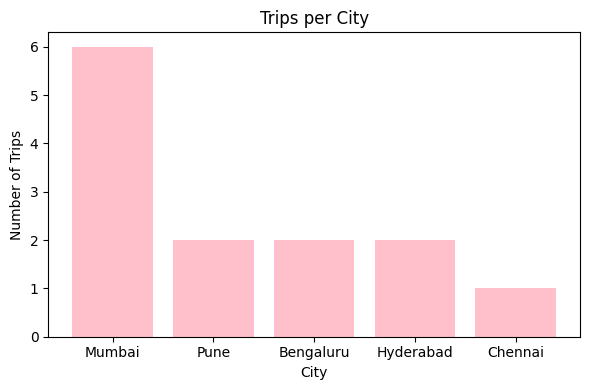

In [54]:
city_trips = (
    gold_df.groupBy("city")
           .count()
           .orderBy(F.desc("count"))
           .toPandas()
)
plt.figure(figsize=(6,4))
plt.bar(city_trips["city"], city_trips["count"], color="pink")
plt.title("Trips per City")
plt.xlabel("City")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

Top drivers by revenue (bar)


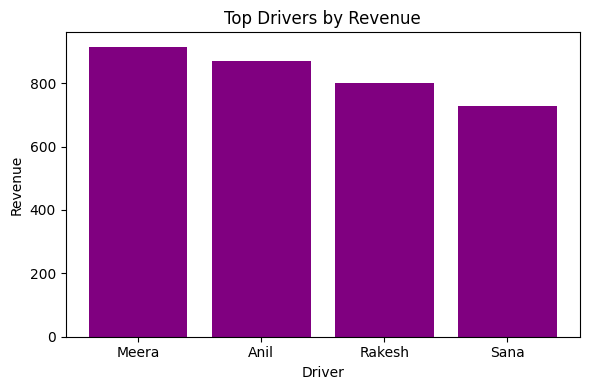

In [55]:
driver_revenue = (
    gold_df.groupBy("driver_name")
           .sum("total_amount")
           .withColumnRenamed("sum(total_amount)", "revenue")
           .orderBy(F.desc("revenue"))
           .limit(5)
           .toPandas()
)
plt.figure(figsize=(6,4))
plt.bar(driver_revenue["driver_name"], driver_revenue["revenue"], color="purple")
plt.title("Top Drivers by Revenue")
plt.xlabel("Driver")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


 Revenue by hour (line)

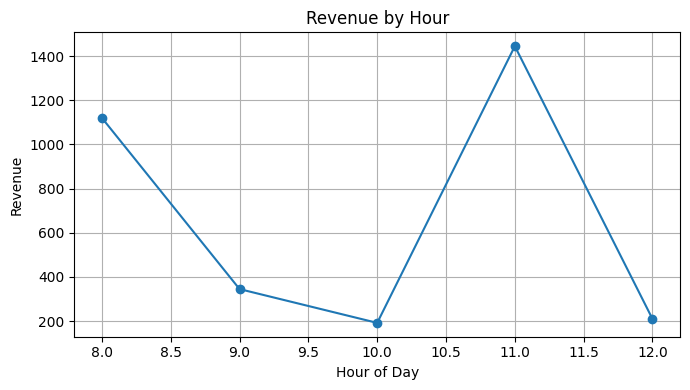

In [56]:
hourly_revenue = (
    gold_df.withColumn("hour", F.hour("ts"))
           .groupBy("hour")
           .sum("total_amount")
           .withColumnRenamed("sum(total_amount)", "revenue")
           .orderBy("hour")
           .toPandas()
)
plt.figure(figsize=(7,4))
plt.plot(hourly_revenue["hour"], hourly_revenue["revenue"], marker="o", linestyle="-")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['teal'])
plt.title("Revenue by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Revenue")
plt.grid(True)
plt.tight_layout()
plt.show()